# GIF Image Format

In [1]:
from struct import unpack_from

import numpy as np
import matplotlib.pyplot as plt

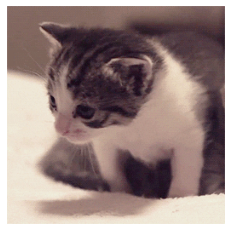

In [2]:
image = plt.imread('cat.gif')
plt.axis('off')
plt.imshow(image)

In [3]:
with open('cat.gif', 'rb') as fp:
    file_data = fp.read()

idx = 0

## Header

In [4]:
print('Signature:', file_data[idx:idx + 3])
idx += 3

Signature: b'GIF'


In [5]:
print('Version:', file_data[idx:idx + 3])
idx += 3

Version: b'89a'


## Logical Screen Descriptor

In [6]:
print('Logical screen width & height:', unpack_from('<HH', file_data, idx))
idx += 4

Logical screen width & height: (256, 256)


In [7]:
packed_fields = file_data[idx]
idx += 1

global_colour_table_flag = (packed_fields >> 7) & 1
print('Global colour table flag:', global_colour_table_flag)

colour_resolution = ((packed_fields >> 4) & 7) + 1
print('Colour resolution:', colour_resolution)

sort_flag = (packed_fields >> 3) & 1
print('Sort flag:', sort_flag)

global_color_table_size = packed_fields & 7
global_color_table_size = 2 ** (global_color_table_size + 1)
print('Size of global colour table:', global_color_table_size)

Global colour table flag: 1
Colour resolution: 8
Sort flag: 0
Size of global colour table: 256


Background colour index:

In [8]:
print('Background colour index:', file_data[idx])
idx += 1

Background colour index: 199


Pixel aspect ratio (0 means no information given):

In [9]:
print('Pixel aspect ratio:', file_data[idx])
idx += 1

Pixel aspect ratio: 0


## Global Colour Table

In [10]:
global_colour_table = np.frombuffer(
    file_data,
    np.uint8,
    global_color_table_size * 3,
    idx,
).reshape((-1, 3))
idx += global_color_table_size * 3

## Graphic Control Extension

In [11]:
print('Extension introducer:', hex(file_data[idx]))
idx += 1

Extension introducer: 0x21


In [12]:
print('Graphic control label:', hex(file_data[idx]))
idx += 1

Graphic control label: 0xf9


In [13]:
print('Block size:', file_data[idx])
idx += 1

Block size: 4


In [14]:
packed_fields = file_data[idx]
idx += 1

print('Reserved:', packed_fields >> 5)
print('Disposal method:', (packed_fields >> 2) & 7)
print('User input flag:', (packed_fields >> 1) & 1)
print('Transparency flag:', packed_fields & 1)

Reserved: 0
Disposal method: 1
User input flag: 0
Transparency flag: 0


In [15]:
delay_time = unpack_from('<H', file_data, idx)[0]
idx += 2
print('Delay time:', delay_time / 100, 'second')

Delay time: 0.1 second


In [16]:
print('Transparency index:', file_data[idx])
idx += 1

Transparency index: 0


In [17]:
print('Block terminator:', file_data[idx])
idx += 1

Block terminator: 0


## Application Extension

In [18]:
print('Extension introducer:', hex(file_data[idx]))
idx += 1

Extension introducer: 0x21


In [19]:
print('Application extension label:', hex(file_data[idx]))
idx += 1

Application extension label: 0xff


In [20]:
print('Block size:', file_data[idx])
idx += 1

Block size: 11


In [21]:
print('Application identifier:', file_data[idx:idx + 8])
idx += 8

Application identifier: b'NETSCAPE'


In [22]:
print('Application authentication code:', file_data[idx:idx + 3])
idx += 3

Application authentication code: b'2.0'


In [23]:
print('Sub-block data size:', file_data[idx])
idx += 1

Sub-block data size: 3


In [24]:
print('Sub-block ID:', file_data[idx])
idx += 1

Sub-block ID: 1


In [25]:
print('Loop count:', unpack_from('<H', file_data, idx)[0])
idx += 2

Loop count: 0


In [26]:
print('Block terminator:', file_data[idx])
idx += 1

Block terminator: 0


## Image Descriptor

In [27]:
print('Image separator', hex(file_data[idx]))
idx += 1

Image separator 0x2c


In [28]:
print('Image left & top position:', unpack_from('<HH', file_data, idx))
idx += 4

Image left & top position: (0, 0)


In [29]:
print('Image width & height:', unpack_from('<HH', file_data, idx))
idx += 4

Image width & height: (256, 256)


In [30]:
packed_fields = file_data[idx]
idx += 1

print('Local colour table flag:', packed_fields >> 7)
print('Interlace flag:', (packed_fields >> 6) & 1)
print('Sort flag:', (packed_fields >> 5) & 1)
print('Reserved:', (packed_fields >> 3) & 2)
print('Size of local colour table:', packed_fields & 7)

Local colour table flag: 0
Interlace flag: 0
Sort flag: 0
Reserved: 0
Size of local colour table: 0


## Table-Based Image Data

In [31]:
min_code_size = file_data[idx]
idx += 1
print('LZW minimum code size:', min_code_size)

LZW minimum code size: 8


In [32]:
lzw_data = b''

while True:
    block_size = file_data[idx]
    idx += 1
    if block_size == 0:
        break
    lzw_data += file_data[idx:idx + block_size]
    idx += block_size

print('Compressed size in bytes:', len(lzw_data))

Compressed size in bytes: 32048


In [33]:
uncompressed_data = []
code_size = min_code_size
decoder_dict = { i: bytes([i]) for i in range(1 << code_size) }
next_unused_code = (1 << code_size) + 2
lzw_idx = 0
lzw_offset = 0


def read_code() -> int:
    global lzw_idx, lzw_offset

    result = 0
    bits_visited = 0
    bits_remaining = code_size + 1
    while bits_remaining != 0:
        bits_part = min(bits_remaining, 8 - lzw_offset)
        part = (lzw_data[lzw_idx] >> lzw_offset) & \
               ((1 << bits_part) - 1)
        result += part << bits_visited
        bits_visited += bits_part
        bits_remaining -= bits_part
        lzw_offset += bits_part
        if lzw_offset == 8:
            lzw_idx += 1
            lzw_offset = 0
    return result


def increment_unused_code() -> None:
    global code_size, next_unused_code
    if next_unused_code is None:
        assert code_size == 11
        return
    next_unused_code += 1
    if next_unused_code == (1 << (code_size + 1)):
        if code_size == 11:
            next_unused_code = None
        else:
            code_size += 1


was_cleared = False

while True:
    lzw_code = read_code()
    if lzw_code == 1 << min_code_size:
        # clear code
        code_size = min_code_size
        decoder_dict = { i: bytes([i]) for i in range(1 << code_size) }
        next_unused_code = (1 << code_size) + 2
        was_cleared = True
        continue
    if lzw_code == (1 << min_code_size) + 1:
        # end of information code
        break
    if lzw_code in decoder_dict:
        if not was_cleared:
            prev_raw_value = uncompressed_data[-1] + \
                             decoder_dict[lzw_code][0:1]
            assert prev_raw_value not in decoder_dict.values()
            decoder_dict[next_unused_code] = prev_raw_value
            increment_unused_code()
    else:
        assert lzw_code == next_unused_code
        raw_value = uncompressed_data[-1] + uncompressed_data[-1][0:1]
        decoder_dict[lzw_code] = raw_value
        increment_unused_code()
    was_cleared = False
    uncompressed_data.append(decoder_dict[lzw_code])

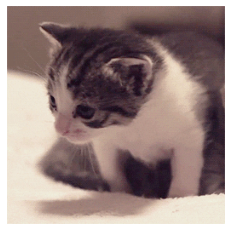

In [34]:
image_indices = np.frombuffer(b''.join(uncompressed_data), np.uint8)
decoded_image = global_colour_table[image_indices].reshape((256, 256, 3))
plt.axis('off')
plt.imshow(decoded_image)